In [5]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch

from models.ddpg import DDPG
from models.model import OUNoise
from env.TradeEnv import TradeEnv

In [6]:
file_path = '../data/processed/'
df_macro = pd.read_csv(file_path + 'macro_data.csv')
df_stock = pd.read_csv(file_path + 'stock_data.csv')
df_factor = pd.read_csv(file_path + 'factor_data.csv')

train_size = int(len(df_stock) * 0.8)
df_macro_train, df_macro_test = df_macro[:train_size], df_macro[train_size:]
df_stock_train, df_stock_test = df_stock[:train_size], df_stock[train_size:]
df_factor_train, df_factor_test = df_factor[:train_size], df_factor[train_size:]

In [7]:
env = TradeEnv(df_macro=df_macro_train, df_factor=df_factor_train, df_stock=df_stock_train)
hidden_size_list = [128, 128] 
agent = DDPG(env=env, hidden_size_list=hidden_size_list)
# noise = OUNoise(action_dim=2)

Initialize trade environment...
Aligning df_macro, df_stock and df_factor...
df_macro shape:  (2139, 54)
df_stock shape:  (2139, 470)
df_factor shape:  (2139, 470)


In [8]:
batch_size = 32
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    # noise.reset()
    episode_reward = 0
    
    for i in range(1,5000):
        action = agent.get_action(state)
        noise = np.clip(np.random.randn(2) * 0.05, -0.05, 0.05)
        action[0] = np.clip(action[0] + noise[0], 0, np.Inf)
        action[1] = np.clip(action[1] + noise[1], -3, 3)
        # action = np.clip(action + noise, -np.Inf, np.Inf)

        next_state, reward, terminated = env.step(action) 
        if not terminated:
            agent.memory.push(state, action, reward, next_state, terminated)
        
            state = next_state
            episode_reward += reward

        if len(agent.memory) > 1e4:
            agent.update(batch_size) 
            if i % 100 == 0:
                print('{}, {:>4d}, {}: {:.7f}'.format(episode, i, action.round(3), episode_reward / i))

        if terminated:
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

9,  400, [ 0.    -0.447]: -0.0002789
9,  500, [ 0.05  -0.563]: -0.0001961
9,  600, [ 0.028 -0.868]: 0.0001274
9,  700, [ 0.025 -2.535]: 0.0006593
9,  800, [ 0.015 -1.957]: 0.0007746
9,  900, [ 0.    -2.966]: 0.0007370
9, 1000, [ 0.016 -0.482]: 0.0007463
10,  100, [ 0.    -1.036]: -0.0001010
10,  200, [0.    1.601]: 0.0005567
10,  300, [ 0.    -2.979]: 0.0003796
10,  400, [0.025 0.653]: -0.0000270
10,  500, [0.    1.505]: 0.0000546
10,  600, [ 0.    -2.916]: 0.0002035
10,  700, [ 0.    -1.705]: 0.0004636
10,  800, [0.035 1.026]: 0.0002854
10,  900, [ 0.    -0.872]: 0.0001470
10, 1000, [0.029 0.57 ]: 0.0001958
11,  100, [ 0.05  -0.287]: -0.0001205
11,  200, [ 0.017 -0.18 ]: 0.0001412
11,  300, [ 0.    -0.368]: -0.0005454
11,  400, [0.    0.473]: -0.0004740
11,  500, [0.    1.898]: -0.0004152
11,  600, [ 0.    -2.817]: -0.0001118
11,  700, [ 0.03  -2.588]: 0.0000082
11,  800, [0.009 0.988]: 0.0000396
11,  900, [ 0.032 -1.962]: -0.0000183
11, 1000, [ 0.    -0.486]: 0.0001036
12,  100, [ 0.

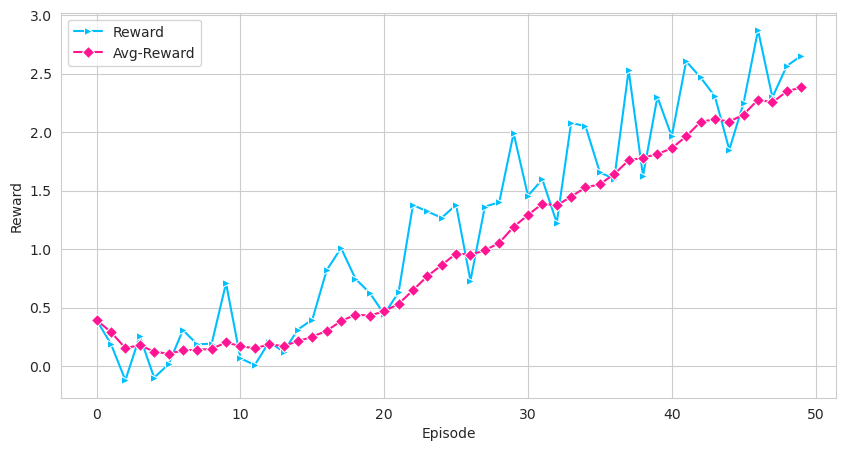

In [9]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(rewards, marker='>', color='deepskyblue', label='Reward')
sns.lineplot(avg_rewards, marker='D', color='deeppink', label='Avg-Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

### Out-of-sample performance

In [10]:
dates = list(set(df_macro['date']) & set(df_factor['date']) & set(df_stock['date']))
cols = list(set(df_factor.columns) & set(df_stock.columns))
data_macro_test = df_macro_test.loc[df_macro['date'].isin(dates)].set_index('date').values
data_factor_test = df_factor_test.loc[df_factor['date'].isin(dates), cols].set_index('date').values
data_stock_test = df_stock_test.loc[df_stock['date'].isin(dates), cols].set_index('date').values

[ 0.        -2.9995136]
[ 0.        -2.9624398]
[ 0.        -0.9852878]
[ 0.        -2.9790087]
[ 0.        -2.9919817]
[0.        1.7921101]
[ 0.        -2.9977808]
[ 0.       -2.999369]
[ 0.       -2.999552]
[0.        0.3715927]
[ 0.        -2.9990237]
[0.         0.02865352]
[ 0.        -0.8599409]
[0.        2.9326725]
[ 0.        -1.9546155]
[ 0.       -2.992495]
[ 0.        -1.5674334]
[0.        1.8638897]
[ 0.        -1.4316682]
[ 0.        -1.6286845]
[ 0.        -2.9582748]
[ 0.        -2.6637316]
[ 0.        -2.1246243]
[ 0.        -2.9782958]
[ 0.        -2.9980028]
[ 0.        -2.7620893]
[ 0.        -1.4943578]
[ 0.        -2.2668808]
[ 0.        -2.9996877]
[ 0.        -1.6809046]
[0.        1.5469832]
[ 0.       -2.598322]
[0.        0.3463806]
[ 0.        -1.9194714]
[0.        1.6339442]
[ 0.         -0.05489797]
[ 0.        -2.9999907]
[ 0.      -2.92073]
[0.       1.763375]
[ 0.        -2.2533875]
[0.        1.2257848]
[ 0.        -2.9939368]
[ 0.        -2.9994233

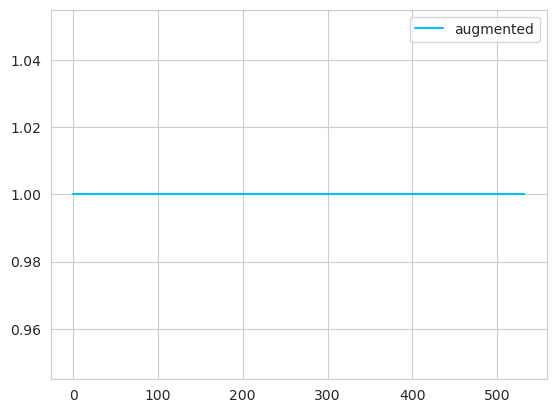

In [11]:
weight = np.zeros(data_stock_test.shape[1])
ret_list = []
for i in range(len(data_macro_test) - 2):
    state = data_macro_test[i].astype(float)
    factor = data_factor_test[i].astype(float)
    action = agent.get_action(state)
    print(action)
    weight_new = env._to_weight(factor, action)
    fee = np.linalg.norm(weight_new - weight, ord=1) * env.fee_ratio
    ret_stock = data_stock_test[i+2] / data_stock_test[i+1] - 1
    ret_net = ret_stock @ weight_new - fee
    ret_list.append(ret_net)
    weight = weight_new   

plt.plot(np.cumprod(1 + np.array(ret_list)), color='deepskyblue', label='augmented')
plt.legend()
plt.show()

## 问题
- action = (scale, threshold), 两个坐标有实际意义，具有异质性，量纲和取值范围不同
- 所以，Actor网络最后一层需要激活函数。Critic是否需要？
- action不加噪声，影响较大，reward不动
- 在日频尺度上，为什么action取值振荡很大